# Neural Efficiency Analysis
In this notebook we explore the neural efficiency metric with quantized models.

In [35]:
%reload_ext autoreload
%autoreload 2

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import *
import pickle
import ast
import os
import sys
from statistics import mean
import warnings

# import modules from common metrics
module_path = os.path.abspath(os.path.join('../../workspace/common/metrics/')) # or the path to your source code
sys.path.insert(0, module_path)
from neural_efficiency import NeuralEfficiency


## Utility methods

In [36]:
def plot_2d_heatmap(values, 
                    title, 
                    min_max=(0, 1), 
                    x_label='Layers', 
                    y_label='Layers', 
                    scale_label='Value', 
                    cmap='Greens',
                    show_value=True):
    '''
    Method used to plot a 2D heatmap using Seaborn.
    '''
    # Set up the figure and axes
    plt.figure(figsize=(7, 6))

    # Create a heatmap using Seaborn
    sns.heatmap(values, 
                cmap=cmap, 
                annot=show_value, 
                fmt=".2f", 
                vmin=min_max[0], 
                vmax=min_max[1],
                cbar_kws={'label': scale_label})

    # Customize the plot
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    # Display the plot
    plt.show()
    
def plot_neural_efficiency_per_layer(neural_efficiency_values, 
                                     title, 
                                     x_label='Layers', 
                                     y_label='Efficiency'):
    plt.figure(figsize=(12,6))
    
    plt.bar(neural_efficiency_values.keys(), 
            neural_efficiency_values.values())

    plt.ylim(0, 1)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)

    # Display the plot
    plt.show()
    
def read_file(file_path, name='neural_efficiency', j_reg=0.0, aug_percentage=0.0, prune=0.0):
    if j_reg > 0:
        name = f"{name}_jreg_{j_reg}"
    elif prune > 0:
        name = f"{name}_prune_{prune}"
    elif aug_percentage > 0:
        name = f"{name}_aug_{aug_percentage}"
    file_path = os.path.join(file_path, f'{name}.pkl')
    
    try:
        with open(file_path, 'rb') as f:
            result = pickle.load(f)
        return result[name]
    except FileNotFoundError:
        print(f"File not found. ({file_path})")
    except Exception as e:
        print("Error occurred:", e)

In [37]:
# search space
batch_sizes = [16, 32, 64, 128, 256, 512, 1024]
learning_rates = [0.1, 0.05, 0.025, 0.0125, 0.00625, 0.003125, 0.0015625]
precisions = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

# ECON model (Autoencoder)
we focus our analysis on the encoder which will be deploy on an ASIC.

In [38]:
DATA_PATH = '/data/tbaldi/work/checkpoint/'
DATASET_DIR = '../../data/ECON/Elegun'
DATASET_FILE = 'nELinks5.npy'

size = 'baseline'

## Results

Neural efficiency require to process an input sample per time. 

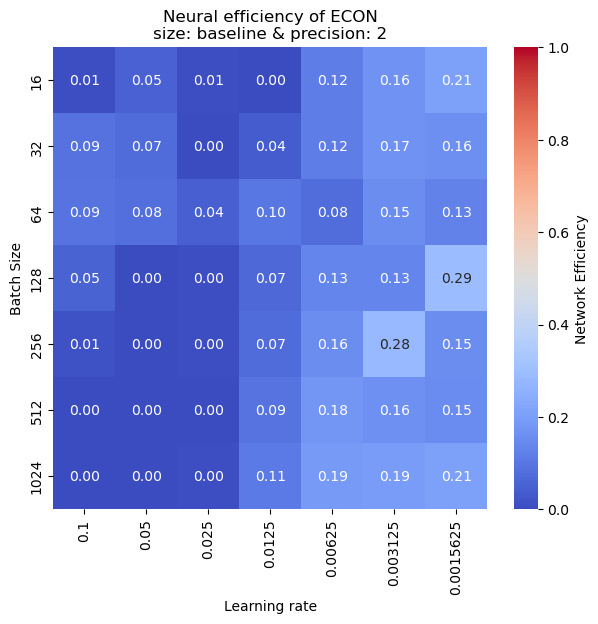

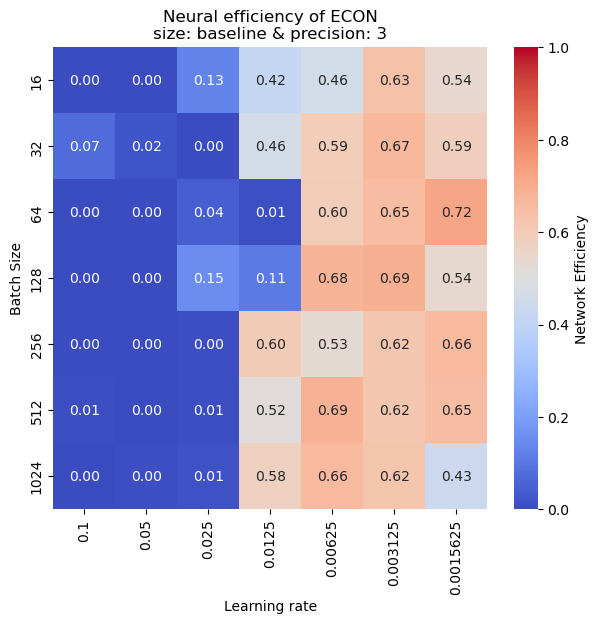

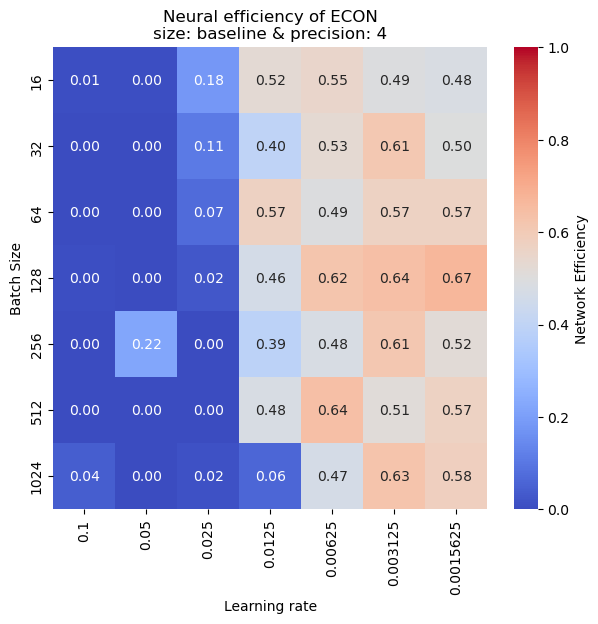

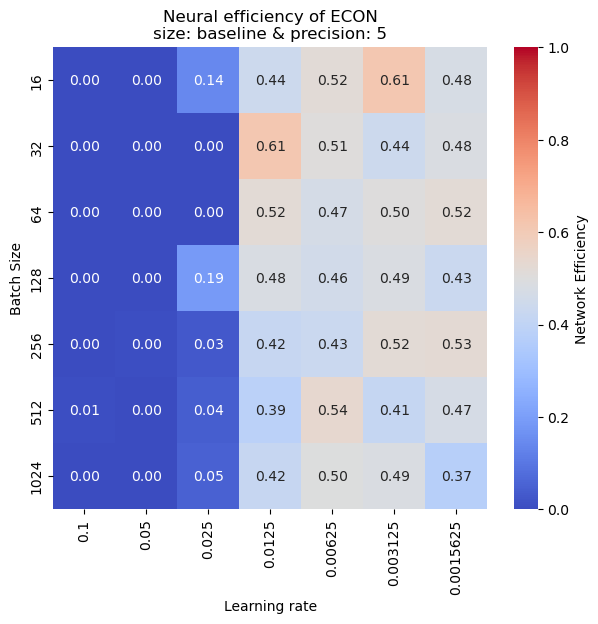

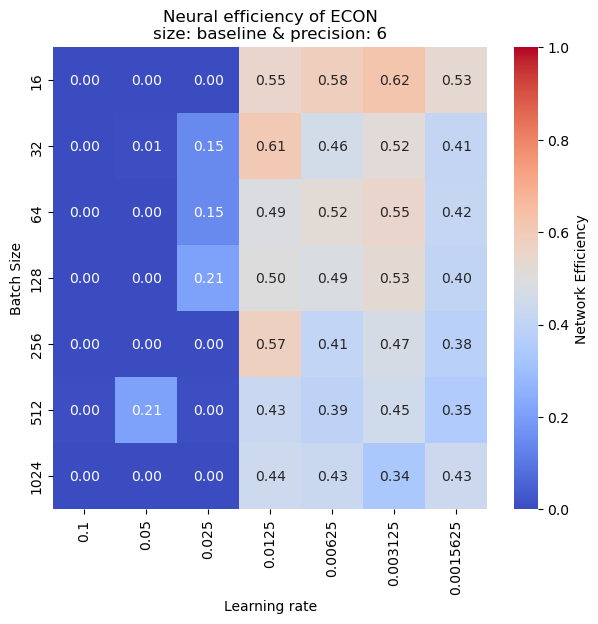

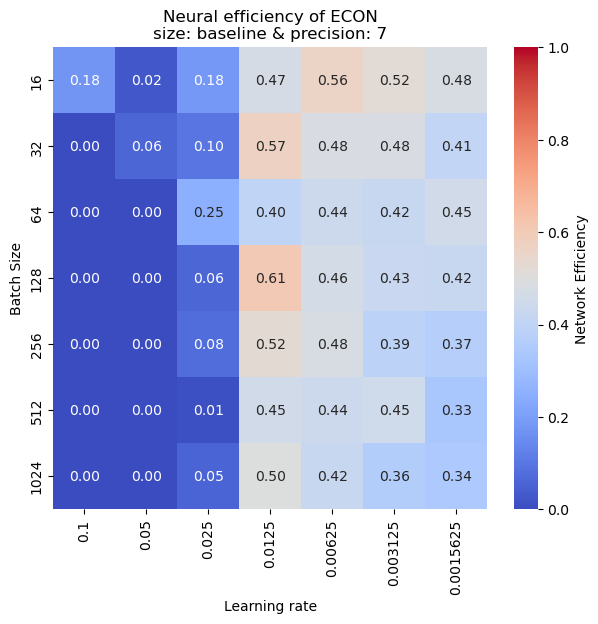

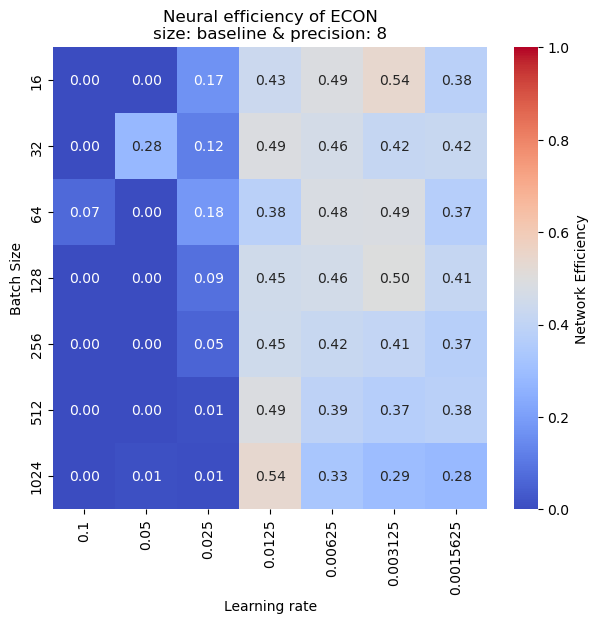

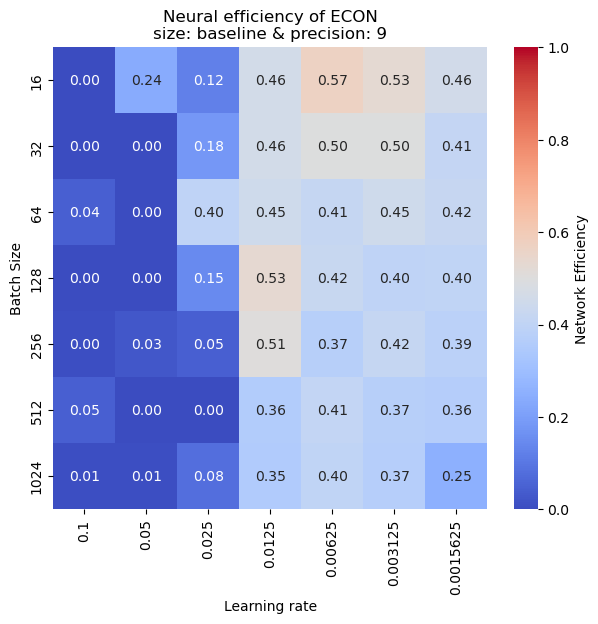

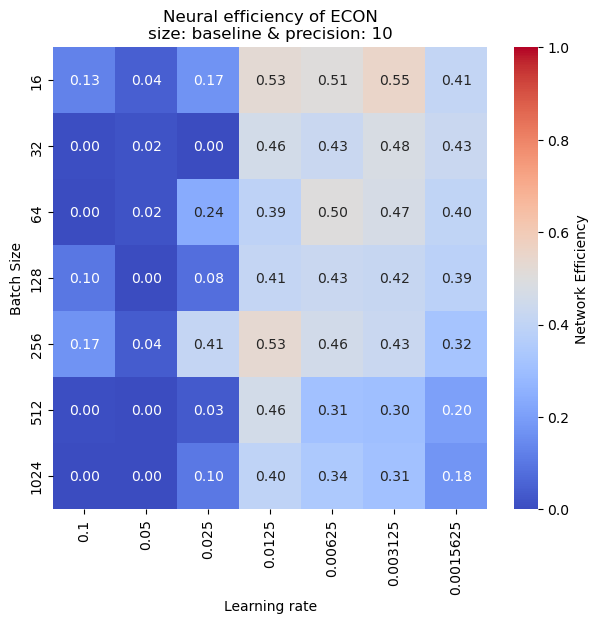

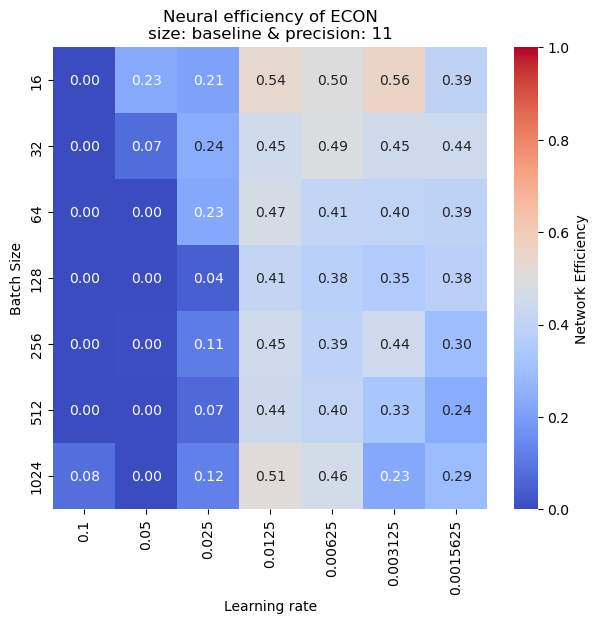

In [39]:
ne_distribution = []
for p in precisions:
    NE_matrix = np.zeros((len(batch_sizes), len(learning_rates)))
    for x, bs in enumerate(batch_sizes):
        for y, lr in enumerate(learning_rates):            
            # load the value from the file
            path = os.path.join(
                DATA_PATH, 
                f'bs{bs}_lr{lr}/ECON_{p}b/{size}/'
            )
            result = -1
            try:
                result = read_file(path)
                result = result['network_efficiency']
            except:
                print("Error: cannot open the file!")
            
            # build the heatmap matrix
            NE_matrix[x, y] = result
            
            # build the dataframe for further analysis
            ne_distribution.append({
                'precision': p, 
                'net_efficiency': result,
                'batch_size': str(bs),
                'learning_rate': str(lr),
            })
            
    # plot the heatmaps per precision
    NE_matrix = pd.DataFrame(NE_matrix, 
                             index=batch_sizes, 
                             columns=learning_rates)
    plot_2d_heatmap(NE_matrix, 
                    f'Neural efficiency of ECON\nsize: {size} & precision: {p}', 
                    (0, 1),
                    'Learning rate',
                    'Batch Size',
                    'Network Efficiency',
                    cmap='coolwarm')
    

In [40]:
ne_distribution_df = pd.DataFrame(ne_distribution)
# export to csv
ne_distribution_df.to_csv('./results/econ/neural_efficiency.csv', index=False)

The batch size is not correlated with EMD and the noise, so we want to plot it based on the precision

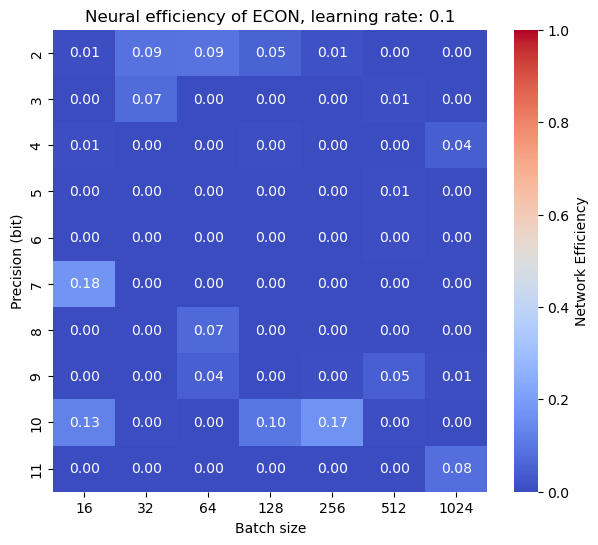

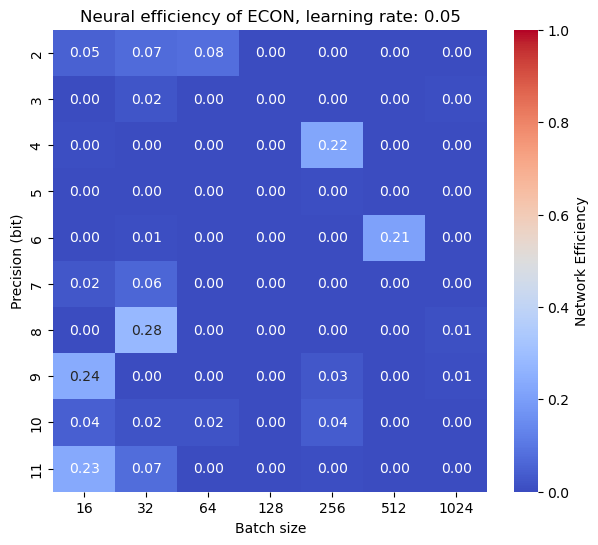

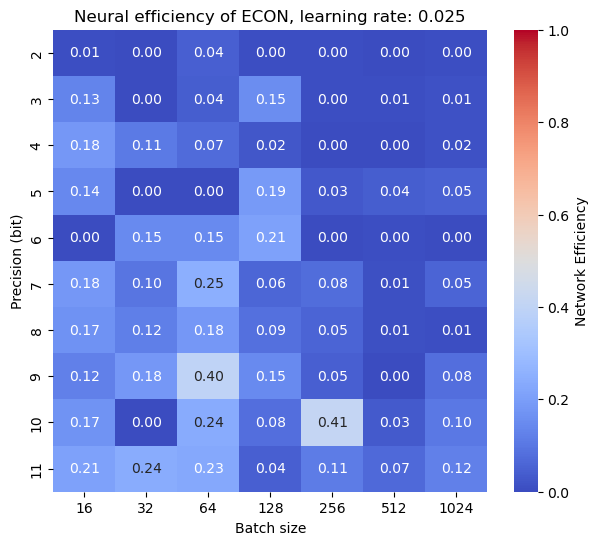

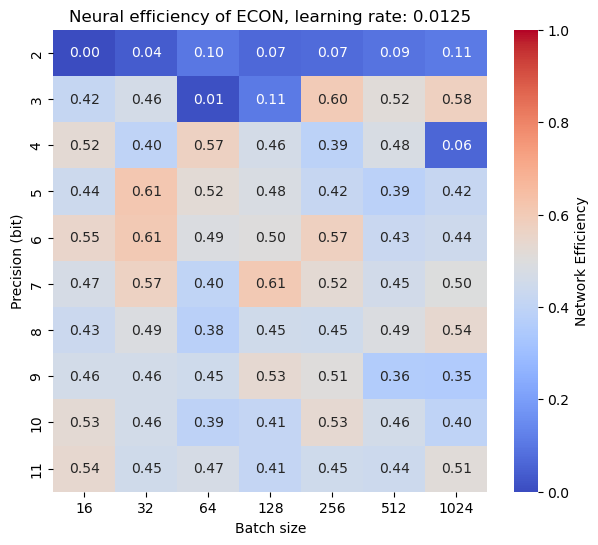

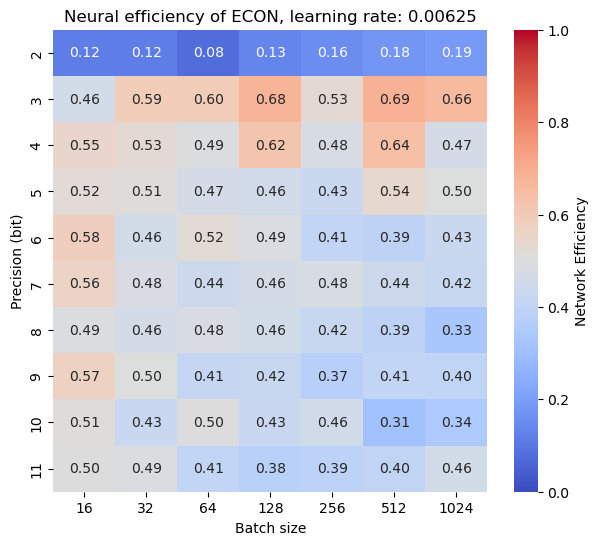

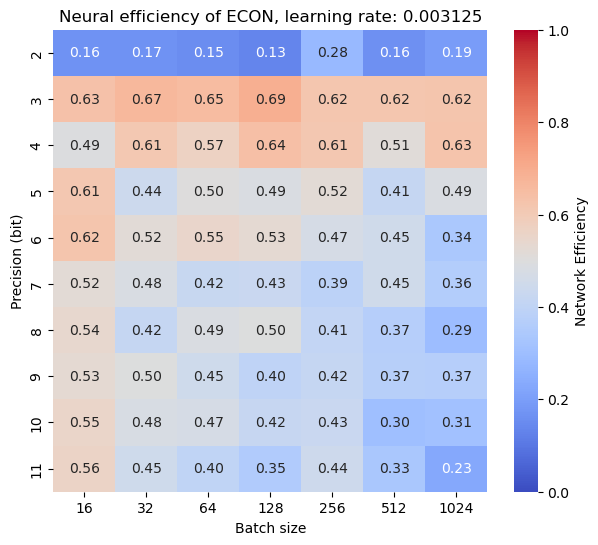

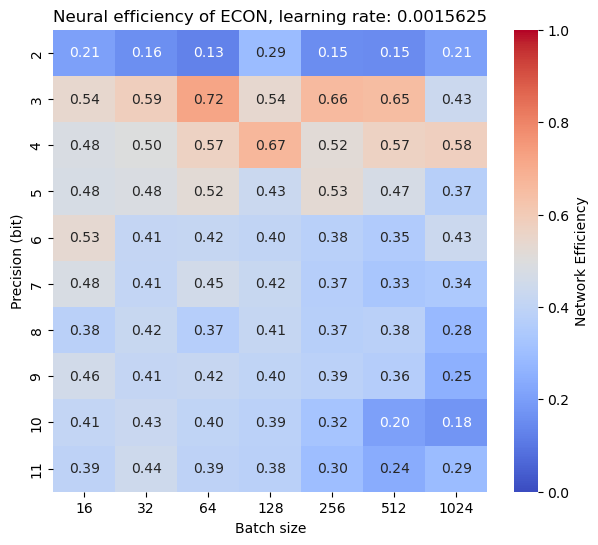

In [41]:

for lr in learning_rates:
    NE_matrix = np.zeros((len(precisions), len(batch_sizes)))
    for y, bs in enumerate(batch_sizes):
        for x, p in enumerate(precisions):
            # load the value from the file
            path = os.path.join(
                DATA_PATH, 
                f'bs{bs}_lr{lr}/ECON_{p}b/{size}/'
            )
            result = -1
            try:
                result = read_file(path)
                result = result['network_efficiency']
            except:
                print("Error: cannot open the file!")
                
            # build the heatmap matrix
            NE_matrix[x, y] = result

            
    # plot the heatmaps per precision
    NE_matrix = pd.DataFrame(NE_matrix, 
                             index=precisions, 
                             columns=batch_sizes)
    plot_2d_heatmap(NE_matrix, 
                    f'Neural efficiency of ECON, learning rate: {lr}', 
                    (0, 1),
                    'Batch size',
                    'Precision (bit)',
                    'Network Efficiency',
                    cmap='coolwarm')
    

## ECON with noise injection

In [42]:
learning_rates = [0.0015625]
batch_sizes = [32, 64, 128, 256, 512, 1024]
aug_percentages = [0.5]

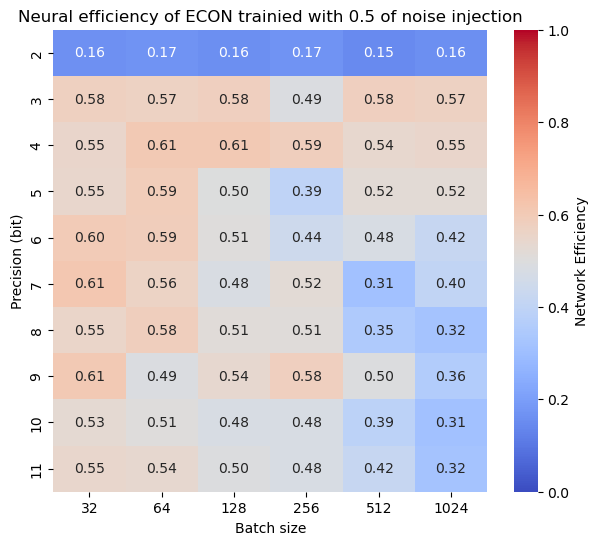

In [43]:
for aug_percentage in aug_percentages:
    for lr in learning_rates:
        NE_matrix = np.zeros((len(precisions), len(batch_sizes)))
        # noise_matrix = np.zeros((len(precisions), len(batch_sizes)))
        for y, bs in enumerate(batch_sizes):
            for x, p in enumerate(precisions):
                path = os.path.join(
                    DATA_PATH, 
                    f'bs{bs}_lr{lr}/ECON_AUG_{p}b/{size}/'
                )
                result = -1
                try:
                    
                    result = read_file(path, aug_percentage=aug_percentage)
                    result = result['network_efficiency']
                except:
                    print("Error: cannot open the file!")
                    
                # build the heatmap matrix
                NE_matrix[x, y] = result

            
    # plot the heatmaps per precision
    NE_matrix = pd.DataFrame(NE_matrix, 
                             index=precisions, 
                             columns=batch_sizes)
    plot_2d_heatmap(NE_matrix, 
                    f'Neural efficiency of ECON trainied with {aug_percentage} of noise injection', 
                    (0, 1),
                    'Batch size',
                    'Precision (bit)',
                    'Network Efficiency',
                    cmap='coolwarm')

## ECON with Jacobian Regularization

In [44]:
learning_rates = [0.0015625]
batch_sizes = [32, 64, 128, 256, 512, 1024]
jreg_percentages = [0.1]

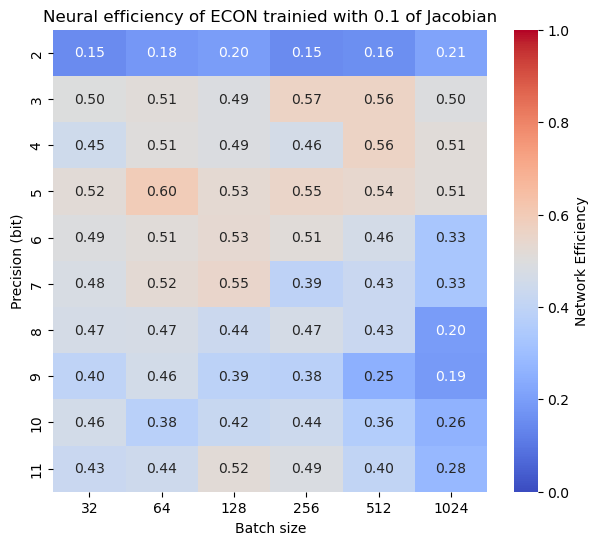

In [45]:
for jreg_percentage in jreg_percentages:
    for lr in learning_rates:
        NE_matrix = np.zeros((len(precisions), len(batch_sizes)))
        # noise_matrix = np.zeros((len(precisions), len(batch_sizes)))
        for y, bs in enumerate(batch_sizes):
            for x, p in enumerate(precisions):
                path = os.path.join(
                    DATA_PATH, 
                    f'bs{bs}_lr{lr}/ECON_JREG_{p}b/{size}/'
                )
                result = -1
                try:
                    
                    result = read_file(path, j_reg=jreg_percentage)
                    result = result['network_efficiency']
                except:
                    print("Error: cannot open the file!")
                    
                # build the heatmap matrix
                NE_matrix[x, y] = result

            
    # plot the heatmaps per precision
    NE_matrix = pd.DataFrame(NE_matrix, 
                             index=precisions, 
                             columns=batch_sizes)
    plot_2d_heatmap(NE_matrix, 
                    f'Neural efficiency of ECON trainied with {jreg_percentage} of Jacobian', 
                    (0, 1),
                    'Batch size',
                    'Precision (bit)',
                    'Network Efficiency',
                    cmap='coolwarm')

## Pruning

In [46]:
learning_rates = [0.0015625]
batch_sizes = [512]
pruning_step = [0, 0.1, 0.25, 0.5, 0.75, 0.9]

In [47]:
ne_distribution = []
for step in pruning_step:
    for lr in learning_rates:
        for y, bs in enumerate(batch_sizes):
            for x, p in enumerate(precisions):
                path = os.path.join(DATA_PATH, f'bs{bs}_lr{lr}/ECON_{p}b/{size}/')
                if step > 0:
                    path = os.path.join(DATA_PATH, f'bs{bs}_lr{lr}/ECON_PRUNE_{p}b/{size}/')
                result = -1
                try:
                    result = read_file(path, prune=step)
                    result = result['network_efficiency']
                except:
                    pass

                # build the heatmap
                ne_distribution.append({
                        'precision': p, 
                        'network efficiency': result,
                        'batch_size': str(bs),
                        'learning_rate': str(lr),
                        'type': f"{int(step * 100)}% pruning"
                    })

File not found. (/data/tbaldi/work/checkpoint/bs512_lr0.0015625/ECON_PRUNE_11b/baseline/neural_efficiency_prune_0.9.pkl)


In [48]:
ne_distribution_df = pd.DataFrame(ne_distribution)
ne_distribution_df.to_csv("./results/econ/prune_neural_efficiency.csv", index=False)
ne_distribution_df.head(30)

,precision,network efficiency,batch_size,learning_rate,type
0,2,0.148950,512,0.0015625,0% pruning
1,3,0.651075,512,0.0015625,0% pruning
2,4,0.568298,512,0.0015625,0% pruning
3,5,0.472234,512,0.0015625,0% pruning
4,6,0.353126,512,0.0015625,0% pruning
5,7,0.330567,512,0.0015625,0% pruning
6,8,0.381637,512,0.0015625,0% pruning
7,9,0.364431,512,0.0015625,0% pruning
8,10,0.204785,512,0.0015625,0% pruning
9,11,0.240375,512,0.0015625,0% pruning


# RN08 (TinyResNet)

In [49]:
DATA_PATH="/data/tbaldi/work/checkpoint/"   
DATASET_DIR = "/data/tbaldi/work/loss_landscape_taxonomy/data/RN08/"

File not found. (/data/tbaldi/work/checkpoint/bs512_lr0.0015625/RN08_2b/neural_efficiency.pkl)
Error: cannot open the file!


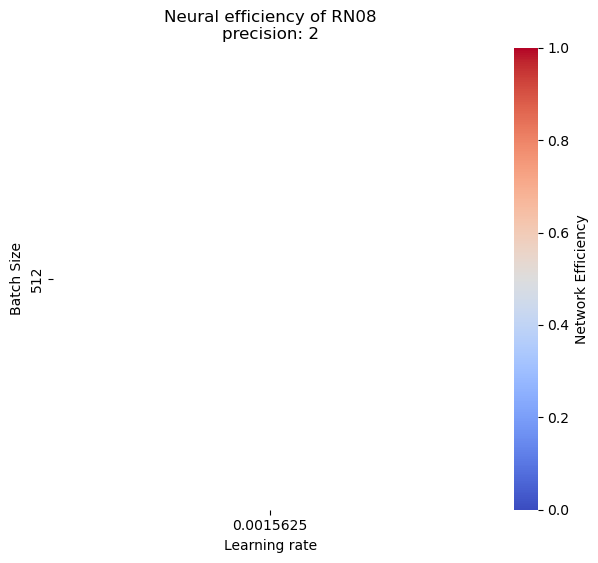

File not found. (/data/tbaldi/work/checkpoint/bs512_lr0.0015625/RN08_3b/neural_efficiency.pkl)
Error: cannot open the file!


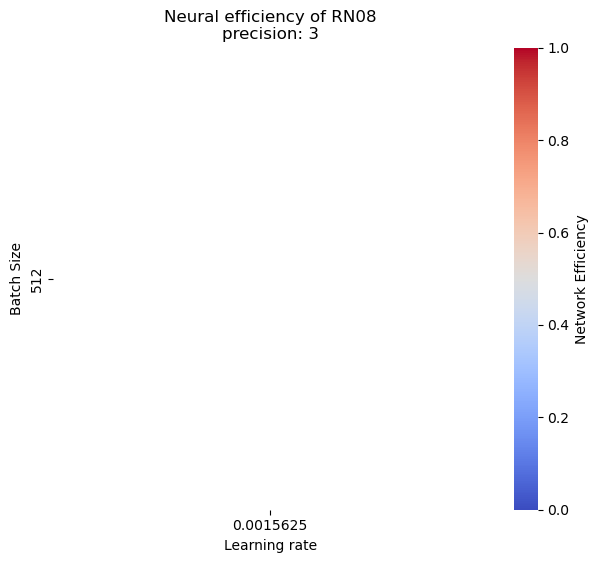

File not found. (/data/tbaldi/work/checkpoint/bs512_lr0.0015625/RN08_4b/neural_efficiency.pkl)
Error: cannot open the file!


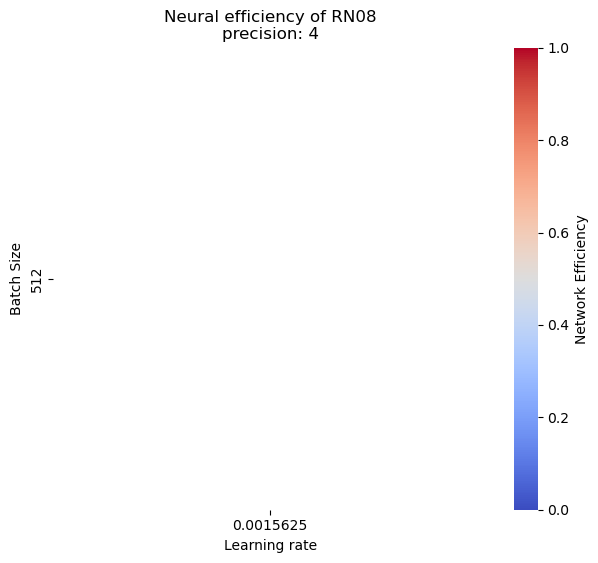

File not found. (/data/tbaldi/work/checkpoint/bs512_lr0.0015625/RN08_5b/neural_efficiency.pkl)
Error: cannot open the file!


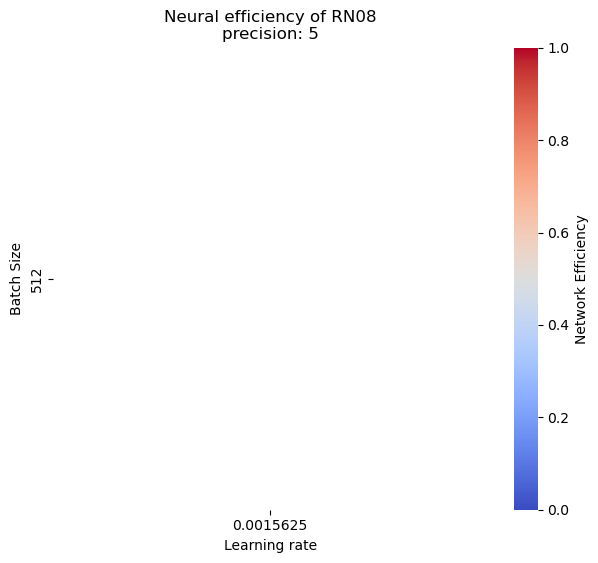

File not found. (/data/tbaldi/work/checkpoint/bs512_lr0.0015625/RN08_6b/neural_efficiency.pkl)
Error: cannot open the file!


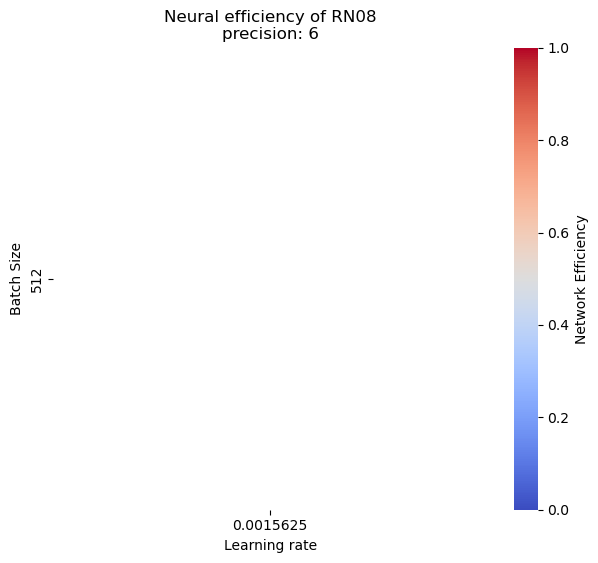

File not found. (/data/tbaldi/work/checkpoint/bs512_lr0.0015625/RN08_7b/neural_efficiency.pkl)
Error: cannot open the file!


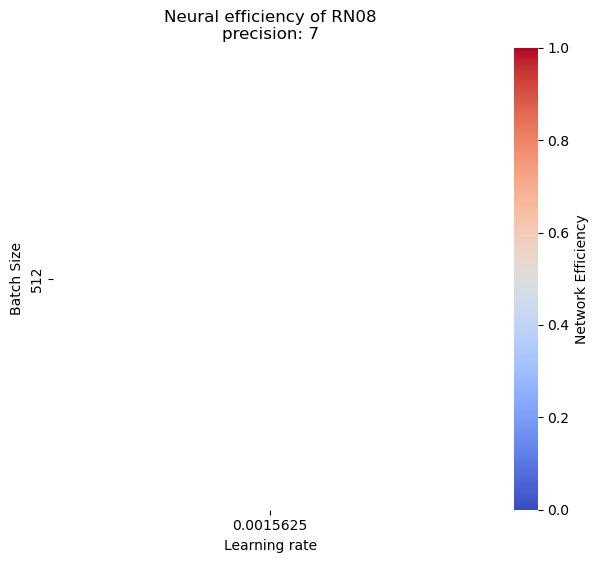

File not found. (/data/tbaldi/work/checkpoint/bs512_lr0.0015625/RN08_8b/neural_efficiency.pkl)
Error: cannot open the file!


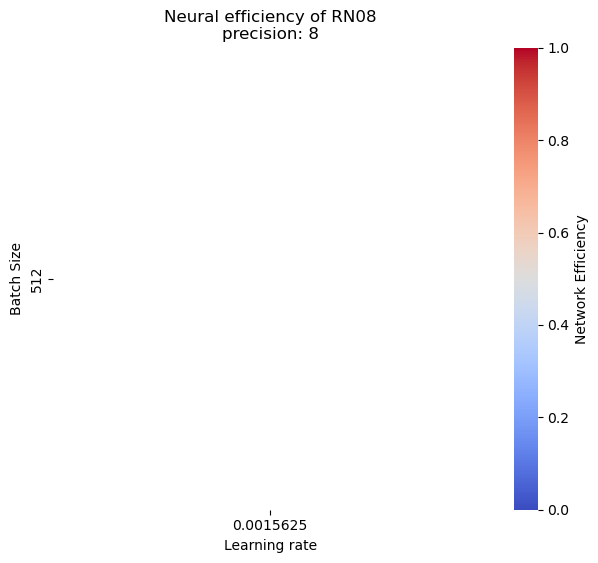

File not found. (/data/tbaldi/work/checkpoint/bs512_lr0.0015625/RN08_9b/neural_efficiency.pkl)
Error: cannot open the file!


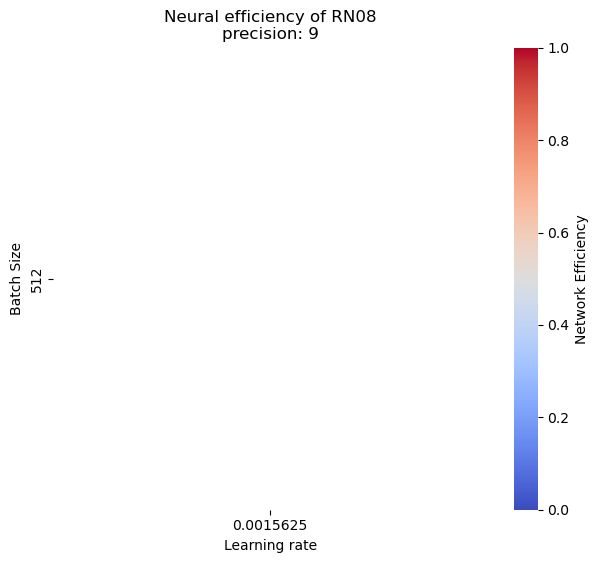

File not found. (/data/tbaldi/work/checkpoint/bs512_lr0.0015625/RN08_10b/neural_efficiency.pkl)
Error: cannot open the file!


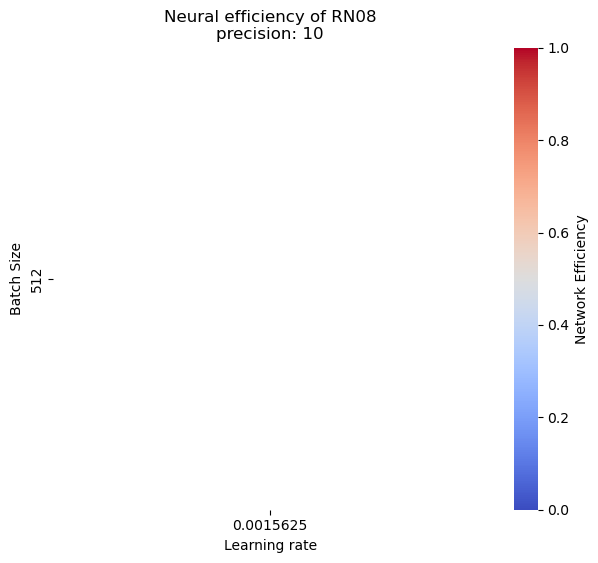

File not found. (/data/tbaldi/work/checkpoint/bs512_lr0.0015625/RN08_11b/neural_efficiency.pkl)
Error: cannot open the file!


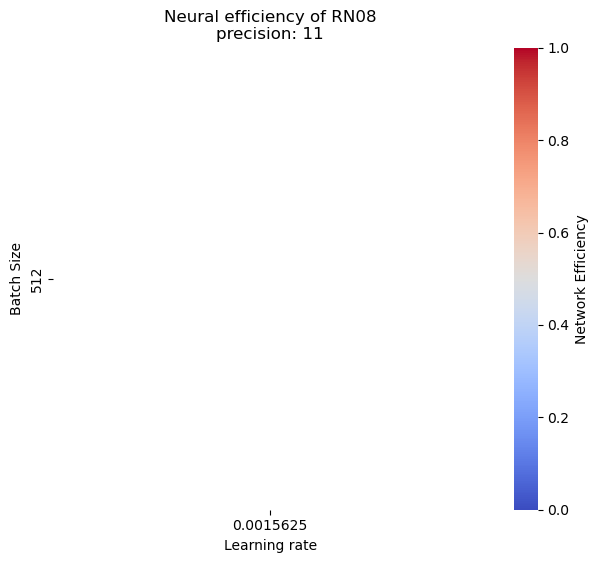

In [50]:
ne_distribution = []
for p in precisions:
    NE_matrix = np.zeros((len(batch_sizes), len(learning_rates)))
    for x, bs in enumerate(batch_sizes):
        for y, lr in enumerate(learning_rates):            
            # load the value from the file
            path = os.path.join(
                DATA_PATH, 
                f'bs{bs}_lr{lr}/RN08_{p}b/'
            )
            
            result = -1
            try:
                result = read_file(path)
                result = result['network_efficiency']
            except:
                print("Error: cannot open the file!")
                
            # build the heatmap matrix
            NE_matrix[x, y] = result
            
            # build the dataframe for further analysis
            ne_distribution.append({
                'precision': p, 
                'net_efficiency': result,
                'batch_size': str(bs),
                'learning_rate': str(lr),
            })
            
    # plot the heatmaps per precision
    NE_matrix = pd.DataFrame(NE_matrix, 
                             index=batch_sizes, 
                             columns=learning_rates)
    
    plot_2d_heatmap(NE_matrix, 
                    f'Neural efficiency of RN08\nprecision: {p}', 
                    (0, 1),
                    'Learning rate',
                    'Batch Size',
                    'Network Efficiency',
                    cmap='coolwarm')

In [51]:
ne_distribution_df = pd.DataFrame(ne_distribution)
ne_distribution_df.to_csv("./results/rn08/neural_efficiency.csv", index=False)